In [1]:
import os
import torch
import numpy as np

import torchvision.transforms as transforms
from datasets import *
from models import *
from displays import *

## Loading and Preparing Dataset

### Parameters and Settings

In [2]:
IMG_HEI, IMG_WID = 160, 320
N_CLASSES = 34

In [3]:
toCuda = lambda x: x.cuda()
G = [
    toCuda,
    #transforms.RandomRotation(degrees=35, 
    #                          interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomResizedCrop(size=(IMG_HEI, IMG_WID), scale=(.2, 1), ratio=(4/5,5/4), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
]
G = transforms.Compose(G)
traintest_transforms = get_transforms2(
    [
        G
    ], [
        transforms.Resize((IMG_HEI, IMG_WID), 
                          interpolation=transforms.InterpolationMode.NEAREST),
    ],
    [
        G,
        #transforms.ColorJitter(brightness=(.5,1.5),contrast=(.8,1.5),saturation=(.5,1.5),hue=(-.1,.1))
    ], [
        transforms.Resize((IMG_HEI, IMG_WID), 
                          interpolation=transforms.InterpolationMode.NEAREST),
    ]
    , n_classes=N_CLASSES, to_tensor=True)

### Functions

In [4]:
# Avoid changing the following code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets

# loading data
dataset = lambda root, train, download, transform, target_transform, **kwargs: \
    CityscapeDataset(
        datasets.Cityscapes(
            root=os.path.join(root, 'cityscapes'), 
            split='train' if train else 'val',
            mode='fine',
            target_type='semantic', 
            **kwargs
        ),
        img_transform=transform,
        targ_transform=target_transform
    )

In [6]:
train_data, val_data = fetch_dataset2(dataset, *traintest_transforms)
train_loader, val_loader = get_dataloader(train_data, val_data, batch_size=16)

### Parameters and Setttings

In [7]:

epoch = 0

LOAD_PATH = None
COMBINE_TRAIN = False
INNER_LOG_DISPLAY = True

In [8]:
#LOAD_PATH = "models/1710510388/249/model_1710744043.h5"
LOAD_PATH = None

In [9]:
# User can set these parameters
batch_size = 128#64

#INITIAL_LR = 1e-4
INITIAL_LR = 5e-5
#GAMMA = .995
GAMMA = .99
#GAMMA = .975

OPTIMIZER = torch.optim.Adam
DECAY_METHOD = torch.optim.lr_scheduler.ExponentialLR

NUM_EPOCHS = 100
NUM_EPOCHS_TO_SAVE = 10

In [10]:
model = UNet(in_channels=3, out_channels=N_CLASSES).to(device)

### Functions

In [11]:
import time
TRAIN_ID = int(time.time())

In [12]:
training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []
training_ious = []
validation_ious = []
lrs = []

In [13]:
# Avoid changing the following code
from torch.utils.data import DataLoader, ConcatDataset
from libs import *

In [14]:
import importlib
import libs
importlib.reload(libs)

<module 'libs' from 'c:\\kht\\ai\\AI Projects (Local)\\proj vision transformer\\libs.py'>

### Training
Start here to continue training.

In [15]:
load_model(model, LOAD_PATH, device=device)
loss_fn, opt, scheduler = set_optimizers(model, loss_fn=nn.CrossEntropyLoss, optimizer=OPTIMIZER, lr=INITIAL_LR, decay=DECAY_METHOD, gamma=GAMMA)

In [16]:
def train_(epochs:int=100, inner_log:bool=False):
    global epoch
    
    if not inner_log:
        print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)

    rng = tqdm(range(epochs)) if not inner_log else range(epochs)
    
    for t in rng:
        if inner_log:
            print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)
        loss, train_accuracy, train_iou, lr = libs.train(train_loader, model, loss_fn, opt, scheduler=scheduler, device=device, log=inner_log)
        val_loss, val_accuracy, val_iou = libs.test(val_loader, model, loss_fn, device=device, log=inner_log)
        training_losses.append(loss)
        validation_losses.append(val_loss)
        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)
        training_ious.append(train_iou)
        validation_ious.append(val_iou)
        lrs.append(lr)

        if epoch <= 5:
            imshow_test(model, val_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)

        epoch += 1
    
    print(f" Train accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {loss:>8f}, lr: {lr}")
    print(f" Test accuracy: {(100*val_accuracy):>0.1f}%, Avg loss: {val_loss:>8f}")

In [17]:
def plot(PTH):
    plt.plot(training_accuracy, label=f'Train Accuracy\nLast: {training_accuracy[-1]}')
    plt.plot(validation_accuracy, label=f'Test Accuracy\nLast: {validation_accuracy[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_accs.png')
    plt.show()

    plt.plot(training_losses, label=f'Train Loss\nLast: {training_losses[-1]}')
    plt.plot(validation_losses, label=f'Test Loss\nLast: {validation_losses[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_losses.png')
    plt.show()

    plt.plot(training_ious, label=f'Train IOUs\nLast: {training_ious[-1]}')
    plt.plot(validation_ious, label=f'Test IOUs\nLast: {validation_ious[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_ious.png')
    plt.show()

    plt.plot(lrs, label=f'Lrs\nFinal: {lrs[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_lrs.png')
    plt.show()

Actual training

c:\kht\ai\AI Projects (Local)\proj vision transformer\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


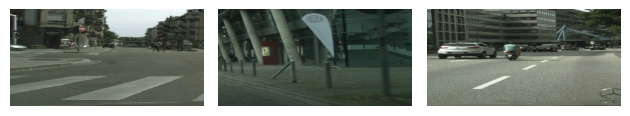

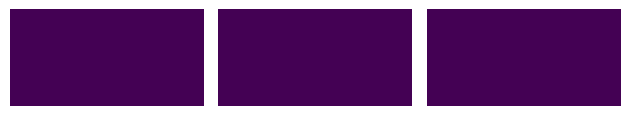

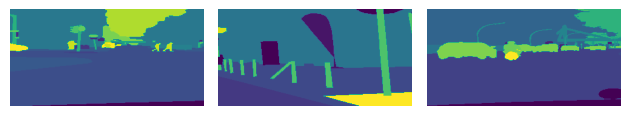

In [18]:
imshow_test(model, train_loader, device, show_reference=True, show_original=True, colorbar=False, softmax=True)

In [19]:
print(device)
libs.test(val_loader, model, loss_fn, device=device, log=True)

cuda


100%|██████████| 32/32 [01:15<00:00,  2.35s/it]

 Test accuracy: 4.745886474847794%, Avg loss: 3.561926029622555, IOU: 0.2776068402454257


(3.561926029622555,
 array(0.04745886, dtype=float32),
 array(0.00277607, dtype=float32))


 =============== Epoch 1 ===============


100%|██████████| 186/186 [12:50<00:00,  4.14s/it]


 Train accuracy: 64.50225710868835%, Avg loss: 2.295846781423015, IOU: 10.211146622896194 lr: 5e-05


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 62.80140280723572%, Avg loss: 2.0961129032075405, IOU: 11.523056030273438


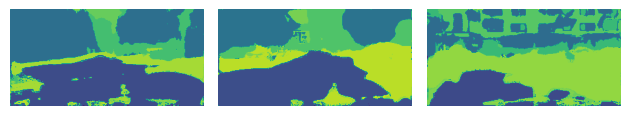


 =============== Epoch 2 ===============


100%|██████████| 186/186 [12:45<00:00,  4.12s/it]


 Train accuracy: 76.01792812347412%, Avg loss: 1.6893019567253769, IOU: 20.760568976402283 lr: 4.9500000000000004e-05


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 71.6265618801117%, Avg loss: 1.728511732071638, IOU: 20.315107703208923


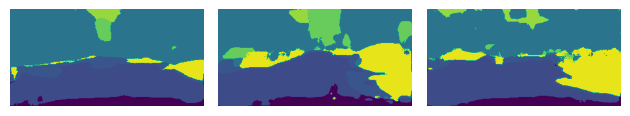


 =============== Epoch 3 ===============


100%|██████████| 186/186 [12:41<00:00,  4.10s/it]


 Train accuracy: 78.4447193145752%, Avg loss: 1.404653024288916, IOU: 26.09403431415558 lr: 4.9005e-05


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


 Test accuracy: 75.24060010910034%, Avg loss: 1.4428272768855095, IOU: 22.50499725341797


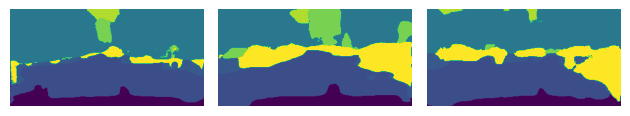


 =============== Epoch 4 ===============


100%|██████████| 186/186 [12:56<00:00,  4.18s/it]


 Train accuracy: 79.87298369407654%, Avg loss: 1.203590158172833, IOU: 27.481821179389954 lr: 4.851495e-05


100%|██████████| 32/32 [01:11<00:00,  2.22s/it]


 Test accuracy: 76.34307742118835%, Avg loss: 1.2518757320940495, IOU: 23.668570816516876


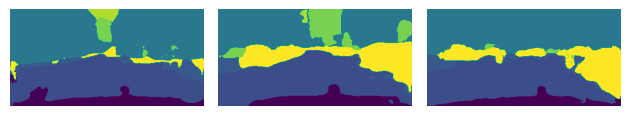


 =============== Epoch 5 ===============


100%|██████████| 186/186 [13:22<00:00,  4.32s/it]


 Train accuracy: 81.00311160087585%, Avg loss: 1.057241024189098, IOU: 28.508374094963074 lr: 4.8029800500000004e-05


100%|██████████| 32/32 [01:12<00:00,  2.28s/it]


 Test accuracy: 76.75707340240479%, Avg loss: 1.1820467710494995, IOU: 24.061143398284912


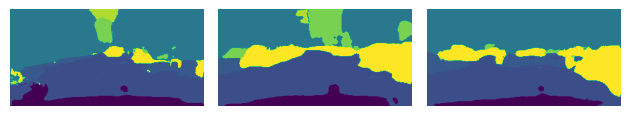


 =============== Epoch 6 ===============


100%|██████████| 186/186 [13:01<00:00,  4.20s/it]


 Train accuracy: 81.78785443305969%, Avg loss: 0.9477301640536195, IOU: 29.26492691040039 lr: 4.7549502495000005e-05


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 77.42995023727417%, Avg loss: 1.0811386201530695, IOU: 24.745866656303406


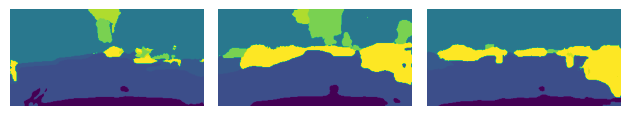


 =============== Epoch 7 ===============


100%|██████████| 186/186 [12:23<00:00,  4.00s/it]


 Train accuracy: 82.73958563804626%, Avg loss: 0.8662714009643883, IOU: 30.562281608581543 lr: 4.707400747005001e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 77.70172953605652%, Avg loss: 1.0368328783661127, IOU: 25.341051816940308

 =============== Epoch 8 ===============


100%|██████████| 186/186 [11:55<00:00,  3.84s/it]


 Train accuracy: 82.91731476783752%, Avg loss: 0.8179993591000957, IOU: 31.16767406463623 lr: 4.660326739534951e-05


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


 Test accuracy: 78.29650044441223%, Avg loss: 0.9702881369739771, IOU: 26.016220450401306

 =============== Epoch 9 ===============


100%|██████████| 186/186 [12:06<00:00,  3.90s/it]


 Train accuracy: 83.22924375534058%, Avg loss: 0.7734256197688401, IOU: 31.574487686157227 lr: 4.6137234721396015e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 77.94576287269592%, Avg loss: 0.954467985779047, IOU: 25.695884227752686

 =============== Epoch 10 ===============


100%|██████████| 186/186 [11:57<00:00,  3.86s/it]


 Train accuracy: 83.68774652481079%, Avg loss: 0.7347047819245246, IOU: 32.119715213775635 lr: 4.567586237418205e-05


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


 Test accuracy: 79.25809025764465%, Avg loss: 0.8961001392453909, IOU: 26.391661167144775
 Train accuracy: 83.7%, Avg loss: 0.734705, lr: 4.567586237418205e-05
 Test accuracy: 79.3%, Avg loss: 0.896100


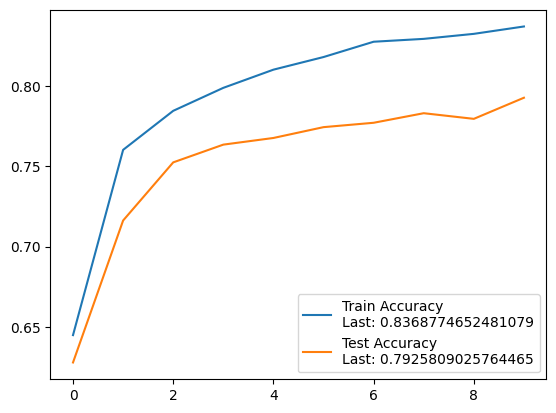

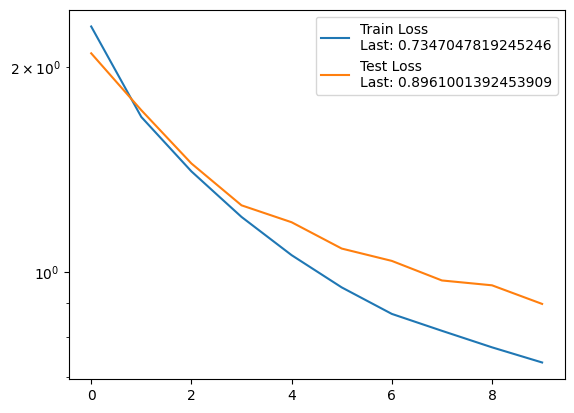

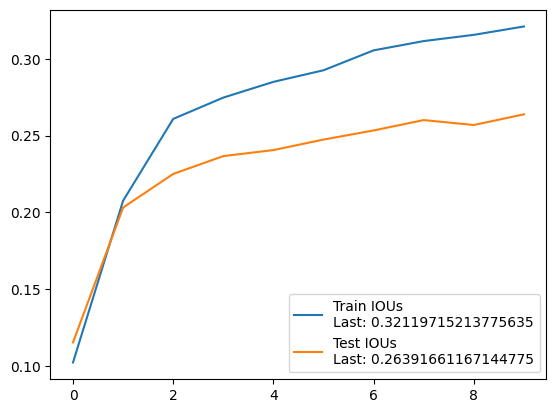

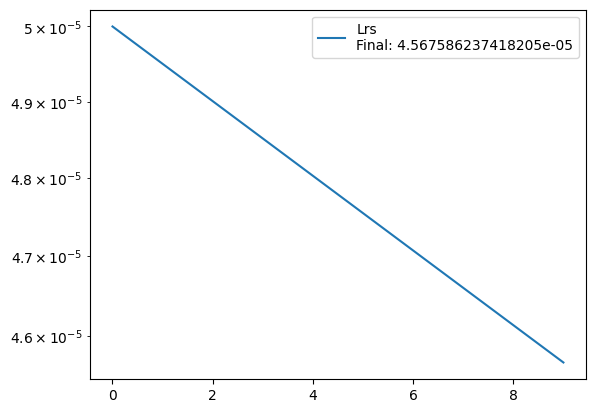

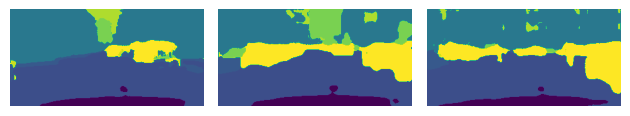


 =============== Epoch 11 ===============


100%|██████████| 186/186 [12:07<00:00,  3.91s/it]


 Train accuracy: 84.0702772140503%, Avg loss: 0.6984329691497229, IOU: 32.79034495353699 lr: 4.5219103750440234e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 79.56704497337341%, Avg loss: 0.865273529663682, IOU: 27.184036374092102

 =============== Epoch 12 ===============


100%|██████████| 186/186 [12:04<00:00,  3.89s/it]


 Train accuracy: 84.31680202484131%, Avg loss: 0.6731481989545207, IOU: 33.05708169937134 lr: 4.4766912712935834e-05


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 78.66208553314209%, Avg loss: 0.8785528801381588, IOU: 26.24310851097107

 =============== Epoch 13 ===============


100%|██████████| 186/186 [11:55<00:00,  3.85s/it]


 Train accuracy: 84.6673846244812%, Avg loss: 0.6462755490054366, IOU: 33.49277675151825 lr: 4.4319243585806474e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 79.94257807731628%, Avg loss: 0.813192056491971, IOU: 27.67719328403473

 =============== Epoch 14 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 84.94979739189148%, Avg loss: 0.621820927627625, IOU: 33.745306730270386 lr: 4.387605114994841e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 80.2256166934967%, Avg loss: 0.7809717813506722, IOU: 27.5923490524292

 =============== Epoch 15 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 85.03773212432861%, Avg loss: 0.6080079051435635, IOU: 33.89079570770264 lr: 4.343729063844893e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 79.62417006492615%, Avg loss: 0.7933289436623454, IOU: 26.9453763961792

 =============== Epoch 16 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 85.28262376785278%, Avg loss: 0.5872425384098484, IOU: 34.139761328697205 lr: 4.3002917732064435e-05


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


 Test accuracy: 79.86564040184021%, Avg loss: 0.7644351664930582, IOU: 27.567467093467712

 =============== Epoch 17 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 85.43148040771484%, Avg loss: 0.5723333057536873, IOU: 34.41663384437561 lr: 4.257288855474379e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 78.54393720626831%, Avg loss: 0.7880875403061509, IOU: 26.802703738212585

 =============== Epoch 18 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 85.41513681411743%, Avg loss: 0.5679292786185459, IOU: 34.20582413673401 lr: 4.214715966919636e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 80.64538836479187%, Avg loss: 0.7459487887099385, IOU: 28.675058484077454

 =============== Epoch 19 ===============


100%|██████████| 186/186 [11:55<00:00,  3.85s/it]


 Train accuracy: 85.6760025024414%, Avg loss: 0.5497974160537925, IOU: 34.64413285255432 lr: 4.1725688072504394e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 81.1552882194519%, Avg loss: 0.7322291703894734, IOU: 28.792160749435425

 =============== Epoch 20 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 86.11341118812561%, Avg loss: 0.5309838636588025, IOU: 35.25726497173309 lr: 4.130843119177935e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 81.08234405517578%, Avg loss: 0.7001447519287467, IOU: 29.229581356048584
 Train accuracy: 86.1%, Avg loss: 0.530984, lr: 4.130843119177935e-05
 Test accuracy: 81.1%, Avg loss: 0.700145


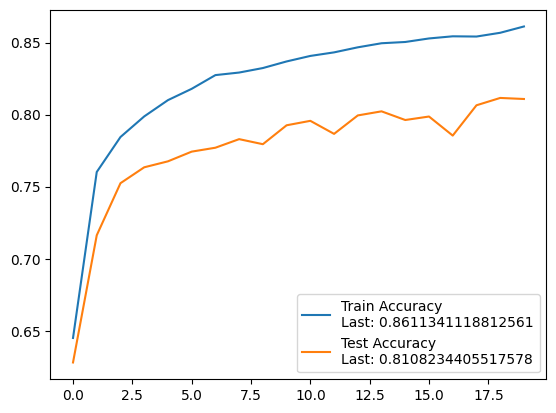

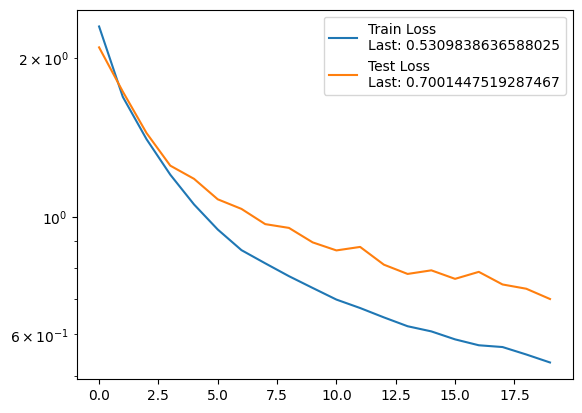

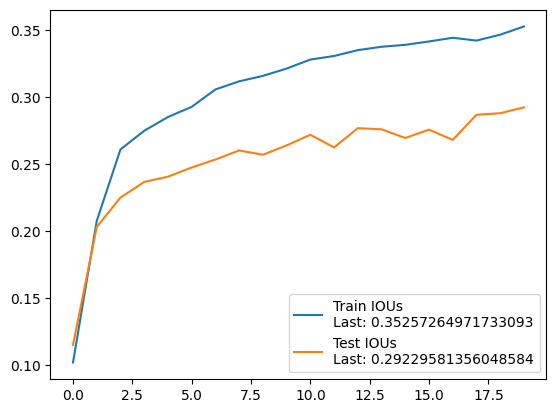

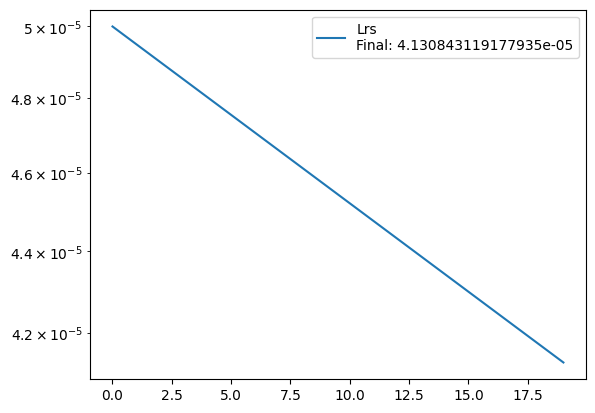

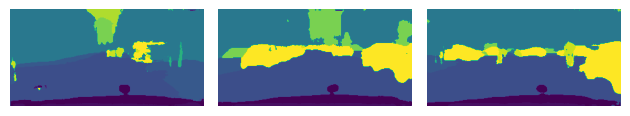


 =============== Epoch 21 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 85.91004610061646%, Avg loss: 0.534021115270994, IOU: 35.09679734706879 lr: 4.089534687986155e-05


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


 Test accuracy: 81.16363883018494%, Avg loss: 0.6921196104958653, IOU: 29.521846771240234

 =============== Epoch 22 ===============


100%|██████████| 186/186 [12:03<00:00,  3.89s/it]


 Train accuracy: 86.35322451591492%, Avg loss: 0.515895749612521, IOU: 35.714784264564514 lr: 4.0486393411062934e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 81.2807023525238%, Avg loss: 0.687068635597825, IOU: 29.684486985206604

 =============== Epoch 23 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 86.66138648986816%, Avg loss: 0.5004162979061886, IOU: 36.01143956184387 lr: 4.0081529476952304e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 81.52683973312378%, Avg loss: 0.6662167655304074, IOU: 29.87823486328125

 =============== Epoch 24 ===============


100%|██████████| 186/186 [11:56<00:00,  3.85s/it]


 Train accuracy: 86.72801852226257%, Avg loss: 0.49230477630451164, IOU: 36.31042242050171 lr: 3.968071418218278e-05


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


 Test accuracy: 82.04485774040222%, Avg loss: 0.6499894317239523, IOU: 30.463314056396484

 =============== Epoch 25 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 86.72976493835449%, Avg loss: 0.4874601904102551, IOU: 36.29309833049774 lr: 3.9283907040360955e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 82.26513266563416%, Avg loss: 0.6435877894982696, IOU: 30.980223417282104

 =============== Epoch 26 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 87.00560927391052%, Avg loss: 0.4737081891426476, IOU: 36.70549392700195 lr: 3.8891067969957344e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 82.55260586738586%, Avg loss: 0.6423863787204027, IOU: 30.928266048431396

 =============== Epoch 27 ===============


100%|██████████| 186/186 [12:00<00:00,  3.88s/it]


 Train accuracy: 86.93347573280334%, Avg loss: 0.4750254578808302, IOU: 36.34394109249115 lr: 3.850215729025777e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 82.63229727745056%, Avg loss: 0.6302433339878917, IOU: 30.84009289741516

 =============== Epoch 28 ===============


100%|██████████| 186/186 [11:55<00:00,  3.85s/it]


 Train accuracy: 87.2572124004364%, Avg loss: 0.4589235394872645, IOU: 36.68143451213837 lr: 3.811713571735519e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 82.11427927017212%, Avg loss: 0.6330880699679255, IOU: 30.1786869764328

 =============== Epoch 29 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 87.27072477340698%, Avg loss: 0.45555119600988203, IOU: 36.76924705505371 lr: 3.773596436018164e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 83.13791751861572%, Avg loss: 0.6047768304124475, IOU: 30.90461492538452

 =============== Epoch 30 ===============


100%|██████████| 186/186 [11:56<00:00,  3.85s/it]


 Train accuracy: 87.46265172958374%, Avg loss: 0.4503075333051784, IOU: 37.02583312988281 lr: 3.735860471657982e-05


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


 Test accuracy: 82.67349600791931%, Avg loss: 0.6180673614144325, IOU: 30.70986568927765
 Train accuracy: 87.5%, Avg loss: 0.450308, lr: 3.735860471657982e-05
 Test accuracy: 82.7%, Avg loss: 0.618067


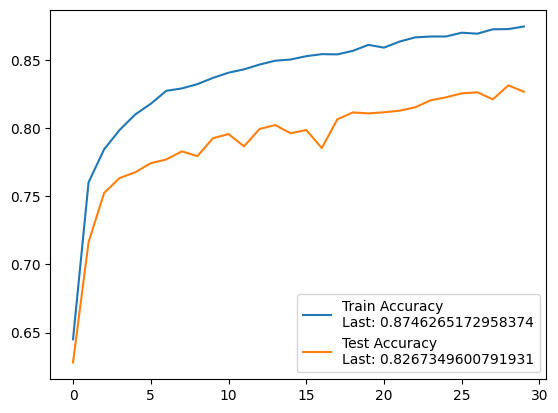

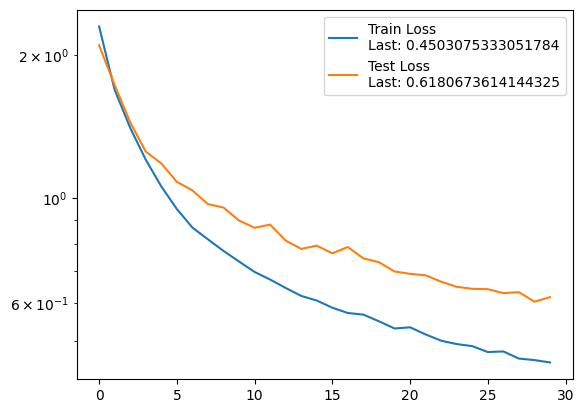

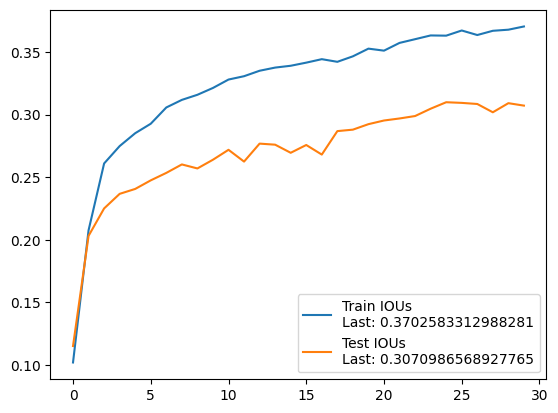

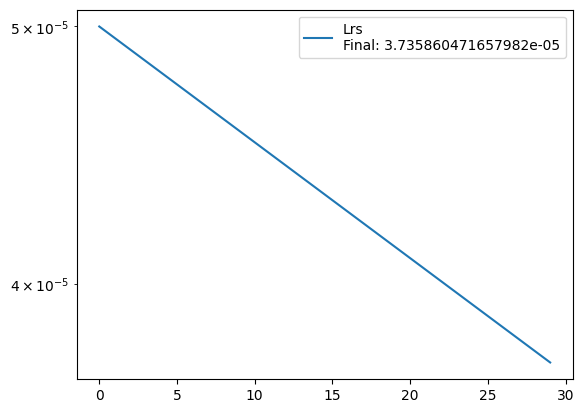

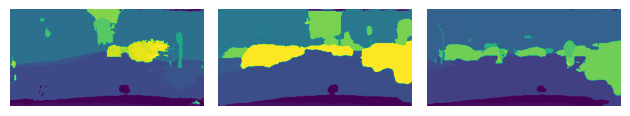


 =============== Epoch 31 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 87.16222047805786%, Avg loss: 0.45695954368960473, IOU: 36.59115731716156 lr: 3.698501866941402e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 83.19270014762878%, Avg loss: 0.6053516231477261, IOU: 31.135395169258118

 =============== Epoch 32 ===============


100%|██████████| 186/186 [11:56<00:00,  3.85s/it]


 Train accuracy: 87.66193389892578%, Avg loss: 0.4395500185989564, IOU: 37.06865906715393 lr: 3.661516848271988e-05


100%|██████████| 32/32 [01:13<00:00,  2.29s/it]


 Test accuracy: 82.94333219528198%, Avg loss: 0.6163598652929068, IOU: 30.60801923274994

 =============== Epoch 33 ===============


100%|██████████| 186/186 [12:25<00:00,  4.01s/it]


 Train accuracy: 87.6285970211029%, Avg loss: 0.43731595415581936, IOU: 37.06407845020294 lr: 3.6249016797892685e-05


100%|██████████| 32/32 [01:11<00:00,  2.23s/it]


 Test accuracy: 83.43468308448792%, Avg loss: 0.5864259134978056, IOU: 31.274372339248657

 =============== Epoch 34 ===============


100%|██████████| 186/186 [12:02<00:00,  3.89s/it]


 Train accuracy: 87.92315721511841%, Avg loss: 0.4234851770183092, IOU: 37.43487596511841 lr: 3.588652662991376e-05


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


 Test accuracy: 83.04674029350281%, Avg loss: 0.6010281266644597, IOU: 31.4987450838089

 =============== Epoch 35 ===============


100%|██████████| 186/186 [11:57<00:00,  3.86s/it]


 Train accuracy: 87.92319297790527%, Avg loss: 0.42196242607408957, IOU: 37.370309233665466 lr: 3.552766136361462e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 83.61321091651917%, Avg loss: 0.5754691315814853, IOU: 31.137865781784058

 =============== Epoch 36 ===============


100%|██████████| 186/186 [12:02<00:00,  3.89s/it]


 Train accuracy: 88.32688331604004%, Avg loss: 0.40897013871900495, IOU: 37.78022527694702 lr: 3.5172384749978474e-05


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 82.95646905899048%, Avg loss: 0.6020361352711916, IOU: 30.775389075279236

 =============== Epoch 37 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 88.48099112510681%, Avg loss: 0.40362319318197104, IOU: 37.74523138999939 lr: 3.482066090247869e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 82.47231841087341%, Avg loss: 0.6033921670168638, IOU: 31.073281168937683

 =============== Epoch 38 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 88.42226266860962%, Avg loss: 0.40423962425801063, IOU: 37.698134779930115 lr: 3.44724542934539e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 83.49609375%, Avg loss: 0.5928527899086475, IOU: 31.578388810157776

 =============== Epoch 39 ===============


100%|██████████| 186/186 [11:57<00:00,  3.86s/it]


 Train accuracy: 88.50025534629822%, Avg loss: 0.4004505140486584, IOU: 37.78865337371826 lr: 3.412772975051936e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 83.62399935722351%, Avg loss: 0.5777625916525722, IOU: 30.999064445495605

 =============== Epoch 40 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 88.63267302513123%, Avg loss: 0.3923972032723888, IOU: 37.91410028934479 lr: 3.378645245301417e-05


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


 Test accuracy: 83.59537124633789%, Avg loss: 0.5754661979153752, IOU: 31.693357229232788
 Train accuracy: 88.6%, Avg loss: 0.392397, lr: 3.378645245301417e-05
 Test accuracy: 83.6%, Avg loss: 0.575466


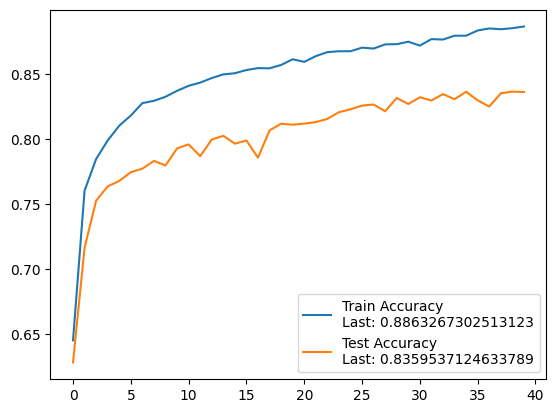

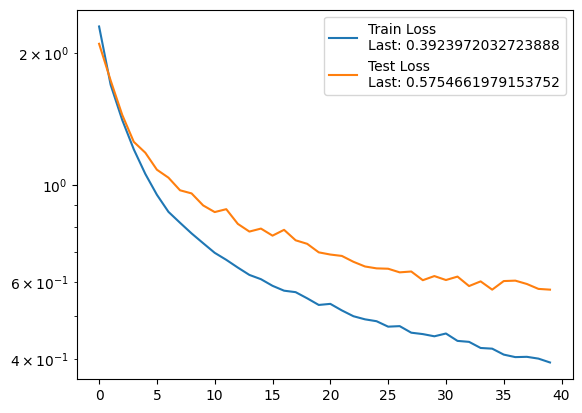

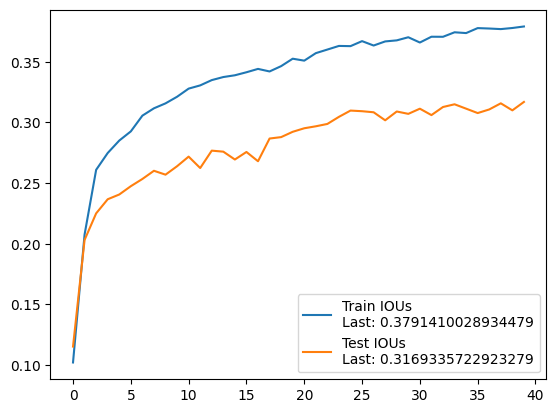

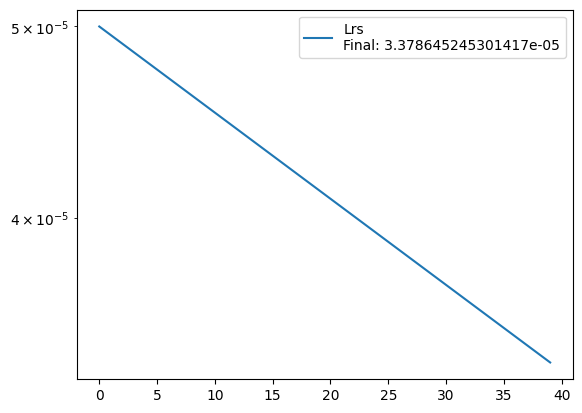

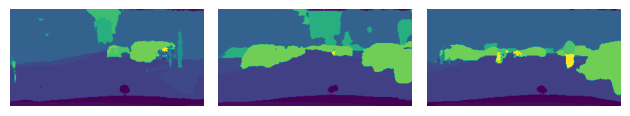


 =============== Epoch 41 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 88.66674304008484%, Avg loss: 0.39185886181169943, IOU: 38.09072971343994 lr: 3.344858792848402e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 83.247309923172%, Avg loss: 0.6046012481674552, IOU: 30.93624711036682

 =============== Epoch 42 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 88.68564367294312%, Avg loss: 0.3902940867889312, IOU: 38.06674778461456 lr: 3.3114102049199184e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 83.76157879829407%, Avg loss: 0.5643488671630621, IOU: 31.61192536354065

 =============== Epoch 43 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 88.65157961845398%, Avg loss: 0.3886938626247068, IOU: 38.10685575008392 lr: 3.2782961028707194e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 83.08953046798706%, Avg loss: 0.5949159245938063, IOU: 32.08364546298981

 =============== Epoch 44 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 89.03733491897583%, Avg loss: 0.37620732388509215, IOU: 38.50082457065582 lr: 3.2455131418420126e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 83.7322473526001%, Avg loss: 0.57656523399055, IOU: 31.72833025455475

 =============== Epoch 45 ===============


100%|██████████| 186/186 [12:04<00:00,  3.89s/it]


 Train accuracy: 88.98045420646667%, Avg loss: 0.37894870340824127, IOU: 38.28110098838806 lr: 3.213058010423592e-05


100%|██████████| 32/32 [01:08<00:00,  2.16s/it]


 Test accuracy: 83.81688594818115%, Avg loss: 0.5565440338104963, IOU: 32.1281760931015

 =============== Epoch 46 ===============


100%|██████████| 186/186 [12:00<00:00,  3.88s/it]


 Train accuracy: 89.15377259254456%, Avg loss: 0.37079043734458184, IOU: 38.26834857463837 lr: 3.180927430319356e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 83.95232558250427%, Avg loss: 0.5563039379194379, IOU: 32.89577662944794

 =============== Epoch 47 ===============


100%|██████████| 186/186 [12:03<00:00,  3.89s/it]


 Train accuracy: 89.20457363128662%, Avg loss: 0.36733073965516144, IOU: 38.52016627788544 lr: 3.149118156016163e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.06928777694702%, Avg loss: 0.5506279785186052, IOU: 33.251774311065674

 =============== Epoch 48 ===============


100%|██████████| 186/186 [12:04<00:00,  3.90s/it]


 Train accuracy: 89.1671359539032%, Avg loss: 0.3686113279833588, IOU: 38.69171440601349 lr: 3.117626974456001e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 83.96457433700562%, Avg loss: 0.5572010343894362, IOU: 32.319316267967224

 =============== Epoch 49 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 89.41869735717773%, Avg loss: 0.3598051851475111, IOU: 38.89869749546051 lr: 3.086450704711441e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 83.75592231750488%, Avg loss: 0.5721977613866329, IOU: 32.38323926925659

 =============== Epoch 50 ===============


100%|██████████| 186/186 [12:10<00:00,  3.93s/it]


 Train accuracy: 89.31363821029663%, Avg loss: 0.3618704682236077, IOU: 38.664957880973816 lr: 3.055586197664326e-05


100%|██████████| 32/32 [01:11<00:00,  2.24s/it]


 Test accuracy: 84.23718810081482%, Avg loss: 0.5693571092560887, IOU: 32.485830783843994
 Train accuracy: 89.3%, Avg loss: 0.361870, lr: 3.055586197664326e-05
 Test accuracy: 84.2%, Avg loss: 0.569357


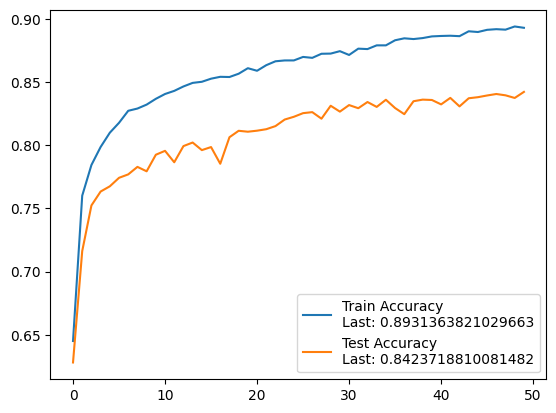

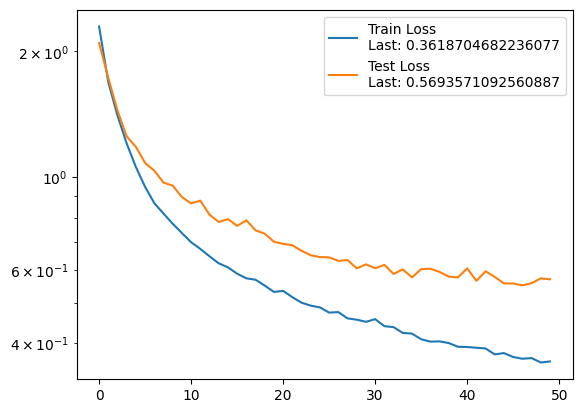

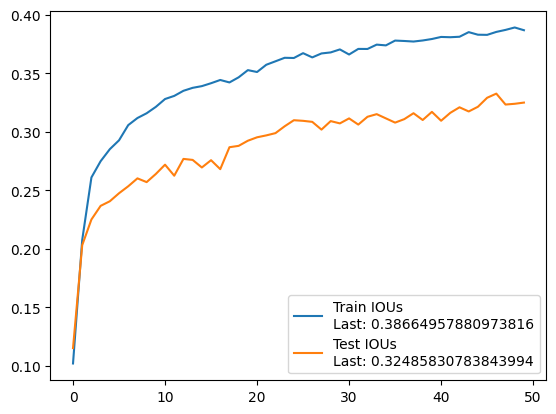

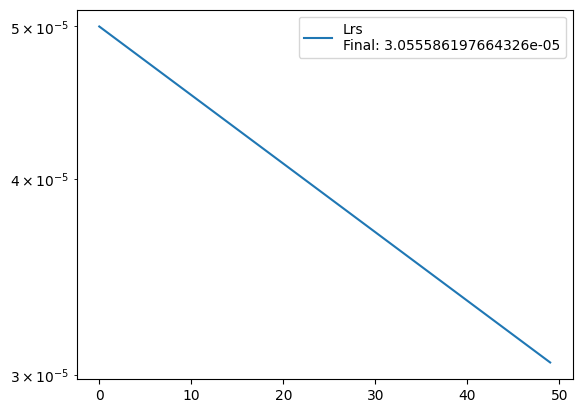

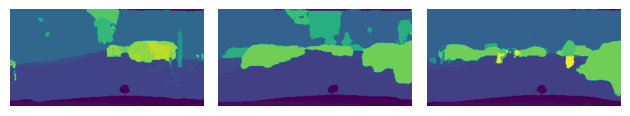


 =============== Epoch 51 ===============


100%|██████████| 186/186 [12:20<00:00,  3.98s/it]


 Train accuracy: 89.40838575363159%, Avg loss: 0.35940406263195057, IOU: 38.6562705039978 lr: 3.025030335687683e-05


100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


 Test accuracy: 84.51424837112427%, Avg loss: 0.5757803879678249, IOU: 33.17050635814667

 =============== Epoch 52 ===============


100%|██████████| 186/186 [13:13<00:00,  4.27s/it]


 Train accuracy: 89.39874172210693%, Avg loss: 0.35879849378139744, IOU: 39.11537528038025 lr: 2.9947800323308063e-05


100%|██████████| 32/32 [01:19<00:00,  2.48s/it]


 Test accuracy: 84.52219367027283%, Avg loss: 0.54619394056499, IOU: 33.468541502952576

 =============== Epoch 53 ===============


100%|██████████| 186/186 [13:34<00:00,  4.38s/it]


 Train accuracy: 89.68496322631836%, Avg loss: 0.3464683463336319, IOU: 39.21986520290375 lr: 2.9648322320074983e-05


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


 Test accuracy: 84.5746099948883%, Avg loss: 0.5460155522450805, IOU: 33.76944065093994

 =============== Epoch 54 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 89.759761095047%, Avg loss: 0.34515421813534153, IOU: 39.57846164703369 lr: 2.9351839096874232e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.16387438774109%, Avg loss: 0.5565463555976748, IOU: 33.291688561439514

 =============== Epoch 55 ===============


100%|██████████| 186/186 [12:03<00:00,  3.89s/it]


 Train accuracy: 89.60340619087219%, Avg loss: 0.35062259043096217, IOU: 39.22057747840881 lr: 2.905832070590549e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.1335654258728%, Avg loss: 0.5691948188468814, IOU: 33.59274864196777

 =============== Epoch 56 ===============


100%|██████████| 186/186 [11:58<00:00,  3.86s/it]


 Train accuracy: 89.67248201370239%, Avg loss: 0.3491313649762061, IOU: 39.1465425491333 lr: 2.8767737498846434e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 83.83771777153015%, Avg loss: 0.5685085244476795, IOU: 33.08515548706055

 =============== Epoch 57 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 89.73910808563232%, Avg loss: 0.3452244359318928, IOU: 39.51357901096344 lr: 2.848006012385797e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.37170386314392%, Avg loss: 0.5710275378078222, IOU: 33.42278301715851

 =============== Epoch 58 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 90.05736708641052%, Avg loss: 0.3337637416778072, IOU: 39.518195390701294 lr: 2.819525952261939e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.41571593284607%, Avg loss: 0.5700953621417284, IOU: 33.04712176322937

 =============== Epoch 59 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 90.0567352771759%, Avg loss: 0.3347207656310451, IOU: 39.75200951099396 lr: 2.7913306927393198e-05


100%|██████████| 32/32 [01:11<00:00,  2.24s/it]


 Test accuracy: 84.5063865184784%, Avg loss: 0.5464452616870403, IOU: 33.60412418842316

 =============== Epoch 60 ===============


100%|██████████| 186/186 [11:56<00:00,  3.85s/it]


 Train accuracy: 90.18340706825256%, Avg loss: 0.3288327104622318, IOU: 39.808809757232666 lr: 2.7634173858119267e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.65381264686584%, Avg loss: 0.5494015300646424, IOU: 33.61272215843201
 Train accuracy: 90.2%, Avg loss: 0.328833, lr: 2.7634173858119267e-05
 Test accuracy: 84.7%, Avg loss: 0.549402


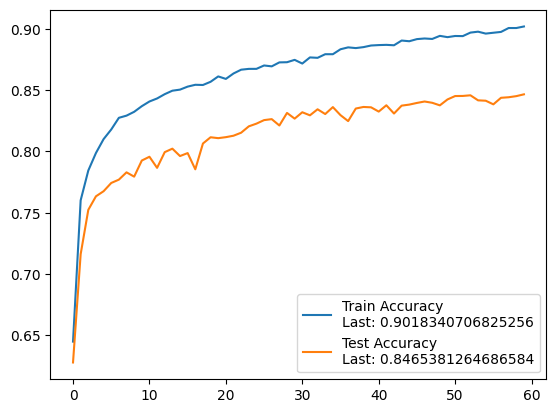

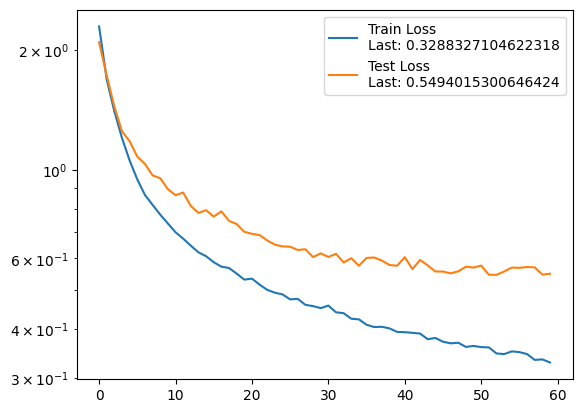

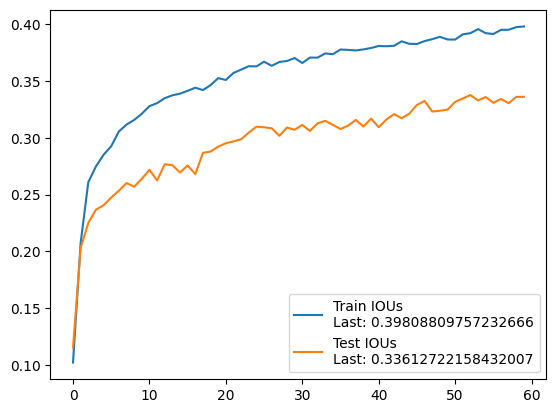

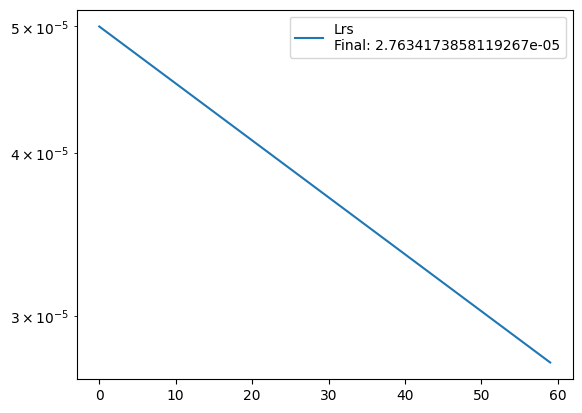

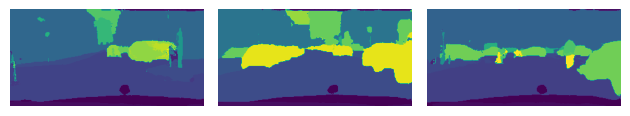


 =============== Epoch 61 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 90.07744193077087%, Avg loss: 0.3318237438797951, IOU: 39.57949876785278 lr: 2.7357832119538075e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.03116464614868%, Avg loss: 0.5528052160516381, IOU: 32.67040550708771

 =============== Epoch 62 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 90.20883440971375%, Avg loss: 0.32744429044185147, IOU: 39.8301899433136 lr: 2.7084253798342694e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.54588651657104%, Avg loss: 0.5505202999338508, IOU: 33.257487416267395

 =============== Epoch 63 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 90.32701849937439%, Avg loss: 0.3229036275097119, IOU: 40.23969769477844 lr: 2.6813411260359266e-05


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]


 Test accuracy: 84.52244997024536%, Avg loss: 0.5611721342429519, IOU: 33.75685513019562

 =============== Epoch 64 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 90.29501080513%, Avg loss: 0.32314354181289673, IOU: 39.965468645095825 lr: 2.6545277147755674e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.60743427276611%, Avg loss: 0.5479995710775256, IOU: 34.29573178291321

 =============== Epoch 65 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 90.51525592803955%, Avg loss: 0.31678906107141125, IOU: 40.20580053329468 lr: 2.6279824376278118e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.72558259963989%, Avg loss: 0.5468346253037453, IOU: 34.57132577896118

 =============== Epoch 66 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 90.43136835098267%, Avg loss: 0.3194145856685536, IOU: 40.01638889312744 lr: 2.6017026132515336e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.46446657180786%, Avg loss: 0.55835538264364, IOU: 32.32231140136719

 =============== Epoch 67 ===============


100%|██████████| 186/186 [12:04<00:00,  3.89s/it]


 Train accuracy: 90.37502408027649%, Avg loss: 0.32172659167679407, IOU: 40.079835057258606 lr: 2.5756855871190182e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.51616168022156%, Avg loss: 0.5422316640615463, IOU: 33.85320603847504

 =============== Epoch 68 ===============


100%|██████████| 186/186 [12:02<00:00,  3.89s/it]


 Train accuracy: 90.51505327224731%, Avg loss: 0.31633326691645447, IOU: 40.433669090270996 lr: 2.549928731247828e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.41221117973328%, Avg loss: 0.5445557981729507, IOU: 33.63676369190216

 =============== Epoch 69 ===============


100%|██████████| 186/186 [12:03<00:00,  3.89s/it]


 Train accuracy: 90.57449698448181%, Avg loss: 0.31271624501033496, IOU: 40.56275188922882 lr: 2.5244294439353498e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.57271456718445%, Avg loss: 0.5643405048176646, IOU: 34.58847999572754

 =============== Epoch 70 ===============


100%|██████████| 186/186 [12:00<00:00,  3.88s/it]


 Train accuracy: 90.59913158416748%, Avg loss: 0.31252692776021135, IOU: 40.252700448036194 lr: 2.4991851494959962e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.97155904769897%, Avg loss: 0.5316767208278179, IOU: 34.444841742515564
 Train accuracy: 90.6%, Avg loss: 0.312527, lr: 2.4991851494959962e-05
 Test accuracy: 85.0%, Avg loss: 0.531677


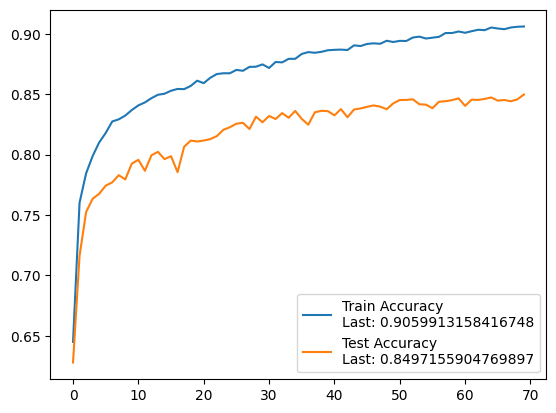

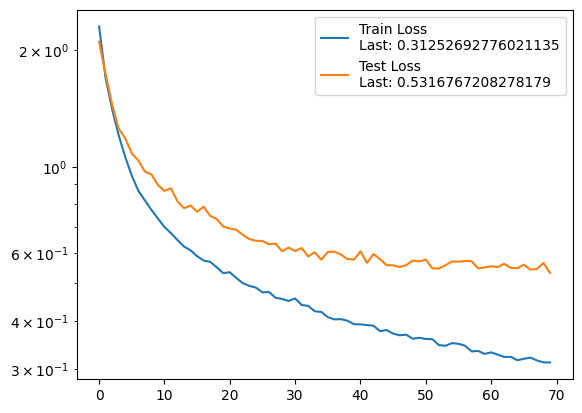

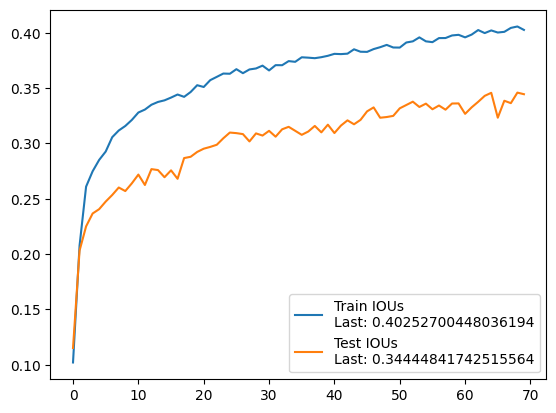

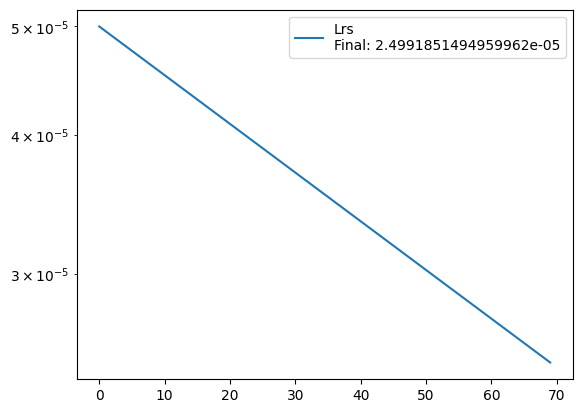

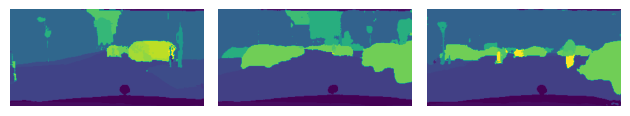


 =============== Epoch 71 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 90.51597118377686%, Avg loss: 0.31506871408031834, IOU: 40.48275351524353 lr: 2.4741932980010363e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.72596406936646%, Avg loss: 0.557956401258707, IOU: 34.36637818813324

 =============== Epoch 72 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 90.73319435119629%, Avg loss: 0.30778505893484237, IOU: 40.683379769325256 lr: 2.449451365021026e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.91058945655823%, Avg loss: 0.5447356076911092, IOU: 34.23891365528107

 =============== Epoch 73 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 90.86394906044006%, Avg loss: 0.3037280566109124, IOU: 40.94226062297821 lr: 2.4249568513708157e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.77161526679993%, Avg loss: 0.555960338562727, IOU: 34.71963107585907

 =============== Epoch 74 ===============


100%|██████████| 186/186 [12:21<00:00,  3.99s/it]


 Train accuracy: 90.82933068275452%, Avg loss: 0.303212148608059, IOU: 40.72175920009613 lr: 2.4007072828571074e-05


100%|██████████| 32/32 [01:12<00:00,  2.27s/it]


 Test accuracy: 84.78350639343262%, Avg loss: 0.5384350856766105, IOU: 34.317055344581604

 =============== Epoch 75 ===============


100%|██████████| 186/186 [12:07<00:00,  3.91s/it]


 Train accuracy: 90.81494808197021%, Avg loss: 0.30320217011756795, IOU: 40.82009792327881 lr: 2.3767002100285364e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.03630757331848%, Avg loss: 0.5387614788487554, IOU: 34.25203859806061

 =============== Epoch 76 ===============


100%|██████████| 186/186 [12:02<00:00,  3.89s/it]


 Train accuracy: 90.90794324874878%, Avg loss: 0.30154263003859466, IOU: 40.856751799583435 lr: 2.352933207928251e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.6323311328888%, Avg loss: 0.5529700787737966, IOU: 34.69926118850708

 =============== Epoch 77 ===============


100%|██████████| 186/186 [12:02<00:00,  3.89s/it]


 Train accuracy: 91.13494753837585%, Avg loss: 0.2930964582389401, IOU: 41.25114679336548 lr: 2.3294038758489684e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.96336340904236%, Avg loss: 0.5485801929607987, IOU: 35.11839509010315

 =============== Epoch 78 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 90.9983217716217%, Avg loss: 0.2967786444451219, IOU: 40.89210331439972 lr: 2.3061098370904787e-05


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]


 Test accuracy: 84.20315980911255%, Avg loss: 0.5603005765005946, IOU: 34.2284232378006

 =============== Epoch 79 ===============


100%|██████████| 186/186 [11:58<00:00,  3.86s/it]


 Train accuracy: 91.12911224365234%, Avg loss: 0.2936347558773974, IOU: 41.05441868305206 lr: 2.283048738719574e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.63496565818787%, Avg loss: 0.5362670654430985, IOU: 34.51687395572662

 =============== Epoch 80 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 91.10289216041565%, Avg loss: 0.2936195214429209, IOU: 40.903159976005554 lr: 2.260218251332378e-05


100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


 Test accuracy: 84.94366407394409%, Avg loss: 0.5470141023397446, IOU: 34.677812457084656
 Train accuracy: 91.1%, Avg loss: 0.293620, lr: 2.260218251332378e-05
 Test accuracy: 84.9%, Avg loss: 0.547014


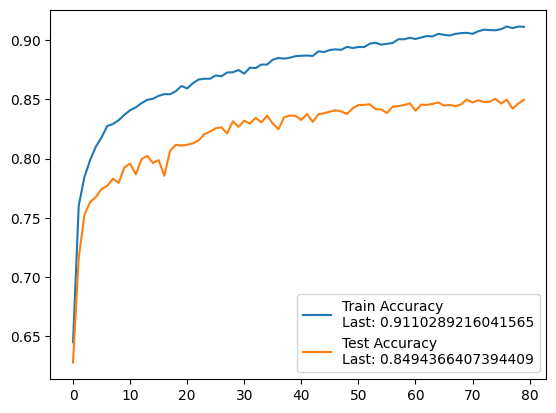

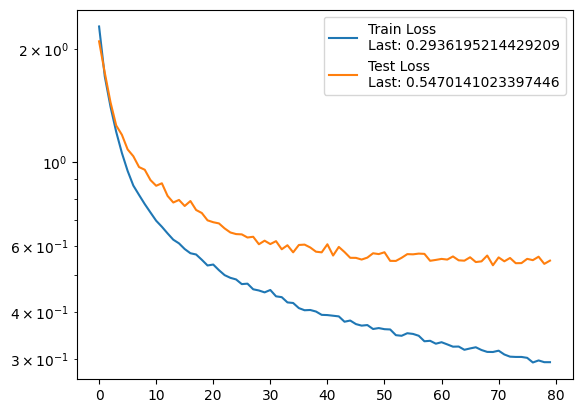

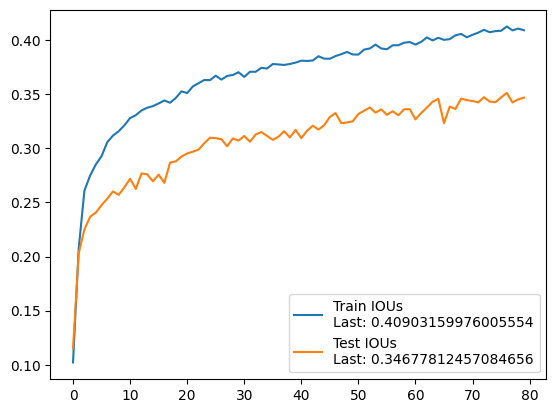

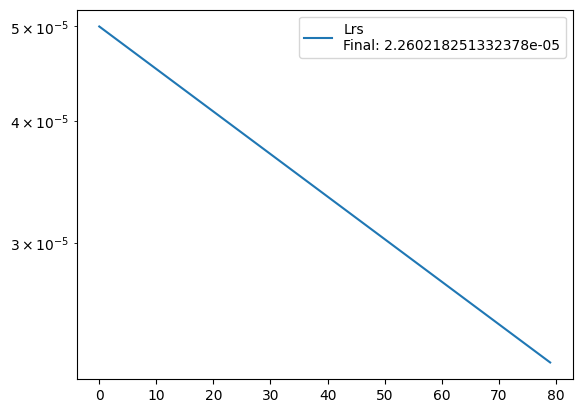

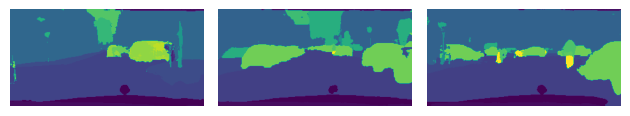


 =============== Epoch 81 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 91.1580502986908%, Avg loss: 0.29100517920588936, IOU: 41.136252880096436 lr: 2.2376160688190544e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.61512923240662%, Avg loss: 0.566051890142262, IOU: 34.05731022357941

 =============== Epoch 82 ===============


100%|██████████| 186/186 [12:06<00:00,  3.90s/it]


 Train accuracy: 91.24186038970947%, Avg loss: 0.28767608610853074, IOU: 41.214609146118164 lr: 2.215239908130864e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 85.04549860954285%, Avg loss: 0.5485697565600276, IOU: 34.784117341041565

 =============== Epoch 83 ===============


100%|██████████| 186/186 [11:56<00:00,  3.85s/it]


 Train accuracy: 91.33102297782898%, Avg loss: 0.2859726660354163, IOU: 41.16947948932648 lr: 2.1930875090495552e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.2685809135437%, Avg loss: 0.5484333541244268, IOU: 35.54675281047821

 =============== Epoch 84 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 91.2410318851471%, Avg loss: 0.2886221994475652, IOU: 41.384655237197876 lr: 2.1711566339590597e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.96473431587219%, Avg loss: 0.5428079115226865, IOU: 34.478989243507385

 =============== Epoch 85 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 91.26027822494507%, Avg loss: 0.2880990696690416, IOU: 41.38995707035065 lr: 2.149445067619469e-05


100%|██████████| 32/32 [01:07<00:00,  2.10s/it]


 Test accuracy: 85.03260612487793%, Avg loss: 0.5424705753102899, IOU: 35.075753927230835

 =============== Epoch 86 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 91.50693416595459%, Avg loss: 0.27965934927104624, IOU: 41.605475544929504 lr: 2.1279506169432744e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.3296160697937%, Avg loss: 0.5269590113312006, IOU: 35.75620353221893

 =============== Epoch 87 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 91.43112897872925%, Avg loss: 0.28101132097103265, IOU: 41.589173674583435 lr: 2.1066711107738416e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 85.29388904571533%, Avg loss: 0.5414776597172022, IOU: 35.81601679325104

 =============== Epoch 88 ===============


100%|██████████| 186/186 [12:02<00:00,  3.88s/it]


 Train accuracy: 91.60067439079285%, Avg loss: 0.2757404338448278, IOU: 41.74400568008423 lr: 2.0856043996661032e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.18680930137634%, Avg loss: 0.5361649747937918, IOU: 35.07437705993652

 =============== Epoch 89 ===============


100%|██████████| 186/186 [12:04<00:00,  3.89s/it]


 Train accuracy: 91.51141047477722%, Avg loss: 0.27858076436865714, IOU: 41.57765805721283 lr: 2.0647483556694422e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.48282384872437%, Avg loss: 0.5366795938462019, IOU: 35.50467789173126

 =============== Epoch 90 ===============


100%|██████████| 186/186 [12:03<00:00,  3.89s/it]


 Train accuracy: 91.64356589317322%, Avg loss: 0.2749980309958099, IOU: 42.036330699920654 lr: 2.0441008721127478e-05


100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


 Test accuracy: 85.1644515991211%, Avg loss: 0.5536855608224869, IOU: 35.38760840892792
 Train accuracy: 91.6%, Avg loss: 0.274998, lr: 2.0441008721127478e-05
 Test accuracy: 85.2%, Avg loss: 0.553686


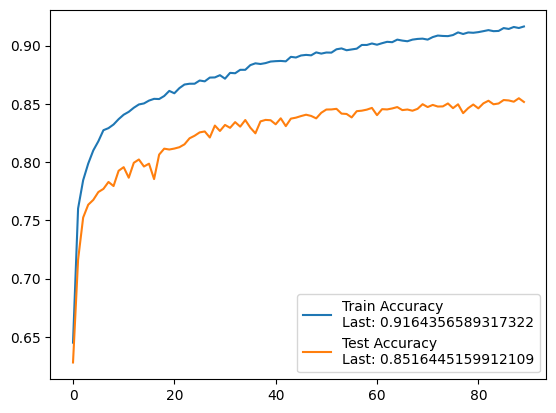

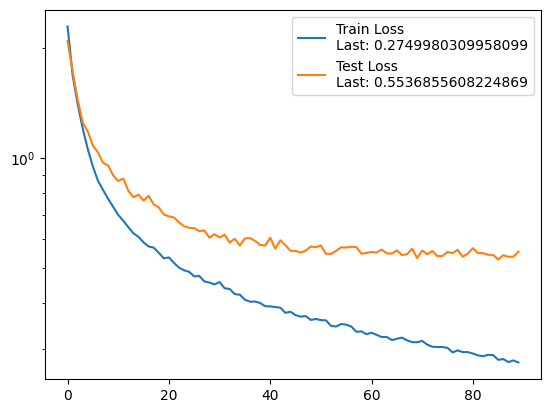

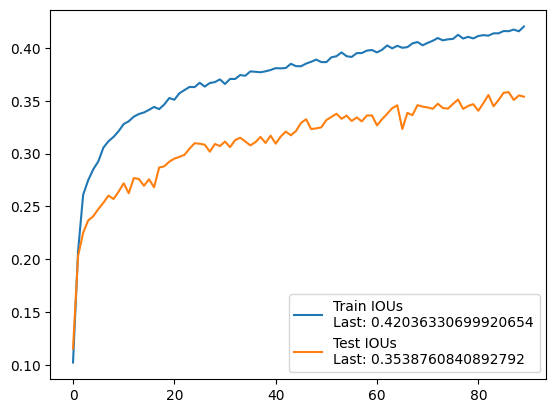

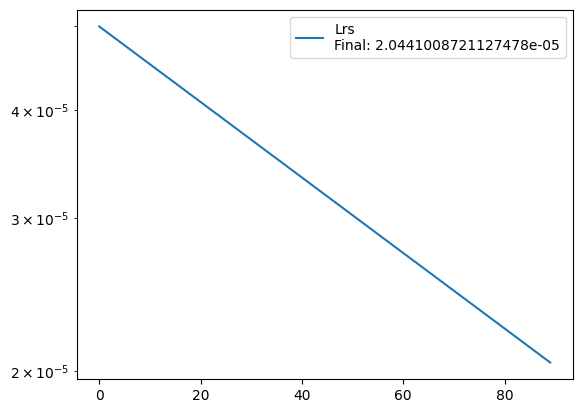

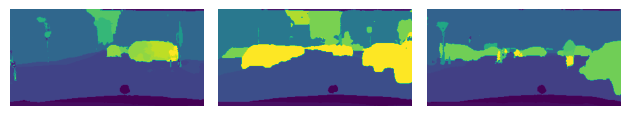


 =============== Epoch 91 ===============


100%|██████████| 186/186 [12:00<00:00,  3.87s/it]


 Train accuracy: 91.81699752807617%, Avg loss: 0.26913377979109365, IOU: 41.958510875701904 lr: 2.02365986339162e-05


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


 Test accuracy: 84.76802706718445%, Avg loss: 0.5565689764916897, IOU: 34.31340754032135

 =============== Epoch 92 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 91.69342517852783%, Avg loss: 0.2725010935657768, IOU: 42.15932488441467 lr: 2.003423264757704e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.81422662734985%, Avg loss: 0.5506588621065021, IOU: 35.09083688259125

 =============== Epoch 93 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 91.66530966758728%, Avg loss: 0.2730209377984847, IOU: 41.99948012828827 lr: 1.983389032110127e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 85.28512120246887%, Avg loss: 0.5431519402191043, IOU: 35.615089535713196

 =============== Epoch 94 ===============


100%|██████████| 186/186 [12:03<00:00,  3.89s/it]


 Train accuracy: 91.6235625743866%, Avg loss: 0.2755427676984059, IOU: 41.9437438249588 lr: 1.9635551417890255e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.31800508499146%, Avg loss: 0.5357231115922332, IOU: 35.30759811401367

 =============== Epoch 95 ===============


100%|██████████| 186/186 [11:58<00:00,  3.86s/it]


 Train accuracy: 91.78064465522766%, Avg loss: 0.2682708027542278, IOU: 42.22451448440552 lr: 1.9439195903711352e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 84.94228720664978%, Avg loss: 0.5417939117178321, IOU: 34.42598581314087

 =============== Epoch 96 ===============


100%|██████████| 186/186 [11:59<00:00,  3.87s/it]


 Train accuracy: 91.92346930503845%, Avg loss: 0.2654189196645573, IOU: 42.35827028751373 lr: 1.9244803944674237e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.10139584541321%, Avg loss: 0.5413408279418945, IOU: 34.99823808670044

 =============== Epoch 97 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 91.88048839569092%, Avg loss: 0.2663667958269837, IOU: 42.22019612789154 lr: 1.9052355905227493e-05


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]


 Test accuracy: 85.55077314376831%, Avg loss: 0.5284586241468787, IOU: 35.376355051994324

 =============== Epoch 98 ===============


100%|██████████| 186/186 [12:06<00:00,  3.90s/it]


 Train accuracy: 91.89106225967407%, Avg loss: 0.26556506063989416, IOU: 42.55325496196747 lr: 1.8861832346175217e-05


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 84.87140536308289%, Avg loss: 0.5411412687972188, IOU: 34.72702205181122

 =============== Epoch 99 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 91.93475842475891%, Avg loss: 0.26432931895858497, IOU: 42.64954328536987 lr: 1.8673214022713464e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.53901314735413%, Avg loss: 0.5317178759723902, IOU: 35.88746190071106

 =============== Epoch 100 ===============


100%|██████████| 186/186 [12:01<00:00,  3.88s/it]


 Train accuracy: 91.79149270057678%, Avg loss: 0.26969446153730475, IOU: 42.25517511367798 lr: 1.848648188248633e-05


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 85.49180030822754%, Avg loss: 0.5234340112656355, IOU: 35.847875475883484
 Train accuracy: 91.8%, Avg loss: 0.269694, lr: 1.848648188248633e-05
 Test accuracy: 85.5%, Avg loss: 0.523434


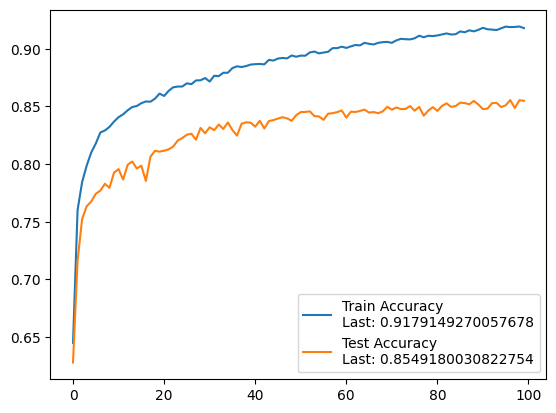

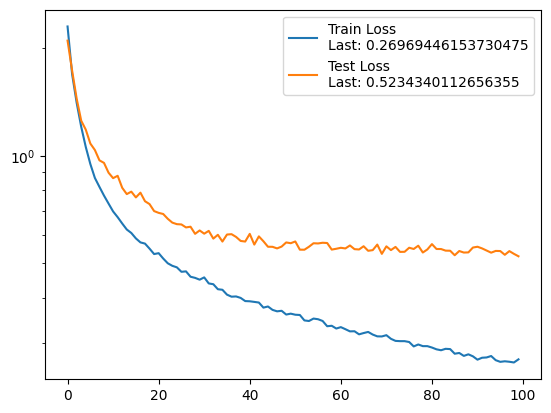

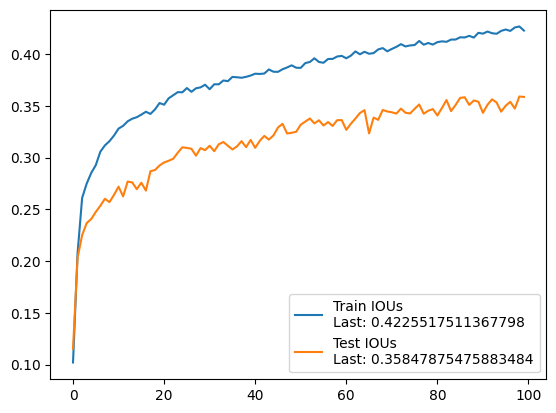

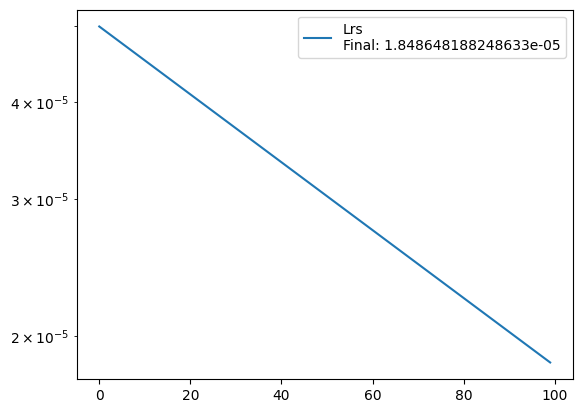

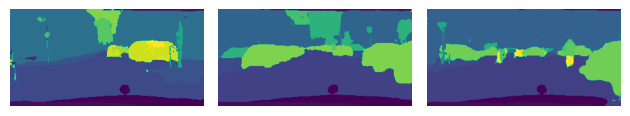

In [20]:
for i in range(NUM_EPOCHS//NUM_EPOCHS_TO_SAVE):
    train_(epochs=NUM_EPOCHS_TO_SAVE, inner_log=INNER_LOG_DISPLAY)
    STORE_PATH = save(os.path.join(str(TRAIN_ID), f'{epoch}'), model, training_accuracy, training_losses, validation_accuracy, validation_losses, lrs)
    plot(STORE_PATH)
    imshow_test(model, val_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)